In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
EXPORT_PATH = os.path.join("..", "export")
DATA_PATH = os.path.join("..", "data")

sys.path.append(SOURCE_PATH)

In [7]:
import fem, tissue, numpy as np
from graphnics import FenicsGraph

TEST_NUM_NODES_EXP = 5

TEST_GRAPH = FenicsGraph()

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

TEST_GRAPH.make_mesh(n = TEST_NUM_NODES_EXP)

TEST_GRAPH.make_submeshes()

TEST_OMEGA, _ = tissue.get_Omega_rect(TEST_GRAPH, bounds = [[0, 0, 0], [0.05, 0.04, 0.03]])

X_ZERO_PLANE = tissue.AxisPlane(0, 0.0)

TEST_CUBES_SOLVER = fem.SubCubes(
    TEST_GRAPH,
    TEST_OMEGA,
    Lambda_inlet_nodes = [0],
    Omega_sink_subdomain = X_ZERO_PLANE,
    lower_cube_bounds = [[0.0, 0.0, 0.0], [0.010, 0.010, 0.010]],
    upper_cube_bounds = [[0.033, 0.030, 0.010],[0.043, 0.040, 0.020]]
)

TEST_CUBES_SOLVER.solve(
    gamma = 3.6145827741262347e-05,
    gamma_a = 8.225197366649115e-08,
    gamma_R = 8.620057937882969e-08,
    mu = 1.0e-3,
    k_t = 1.0e-10,
    P_in = 100.0 * 133.322,
    P_cvp = 1.0 * 133.322
)

TEST_CUBES_SOLVER.compute_net_flow_all_dolfin()

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2086.48it/s]


5.000000000597952e-06

Node Pressure Data:
Node 0: Pressure 13332.2
Node 113: Pressure 13332.3
Node 57: Pressure 13332.4
Node 114: Pressure 13332.4
Node 29: Pressure 13332.4
Node 116: Pressure 13332.4
Node 58: Pressure 13332.4
Node 115: Pressure 13332.4
Node 15: Pressure 13332.3
Node 119: Pressure 13332.2
Node 60: Pressure 13332.1
Node 120: Pressure 13331.9
Node 30: Pressure 13331.7
Node 118: Pressure 13331.5
Node 59: Pressure 13331.3
Node 117: Pressure 13331.0
Node 8: Pressure 13330.7
Node 125: Pressure 13330.4
Node 63: Pressure 13330.1
Node 126: Pressure 13329.7
Node 32: Pressure 13329.3
Node 128: Pressure 13328.9
Node 64: Pressure 13328.4
Node 127: Pressure 13327.9
Node 16: Pressure 13327.4
Node 123: Pressure 13326.9
Node 62: Pressure 13326.3
Node 124: Pressure 13325.7
Node 31: Pressure 13325.1
Node 122: Pressure 13324.4
Node 61: Pressure 13323.7
Node 121: Pressure 13323.0
Node 1: Pressure 13322.3


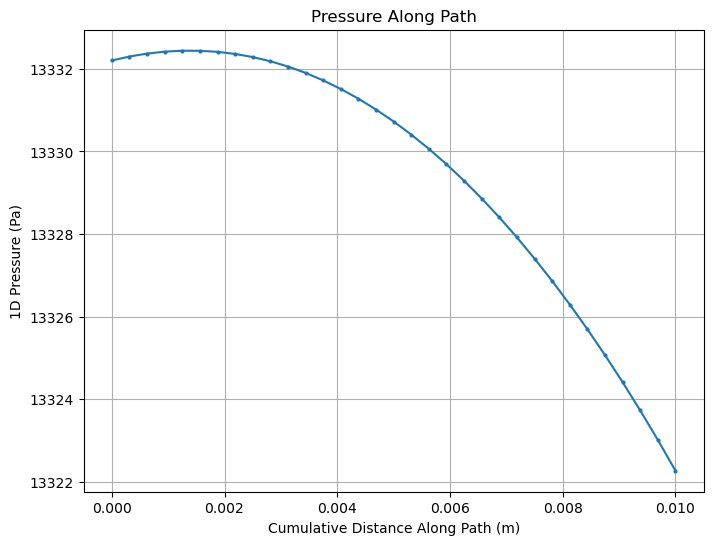

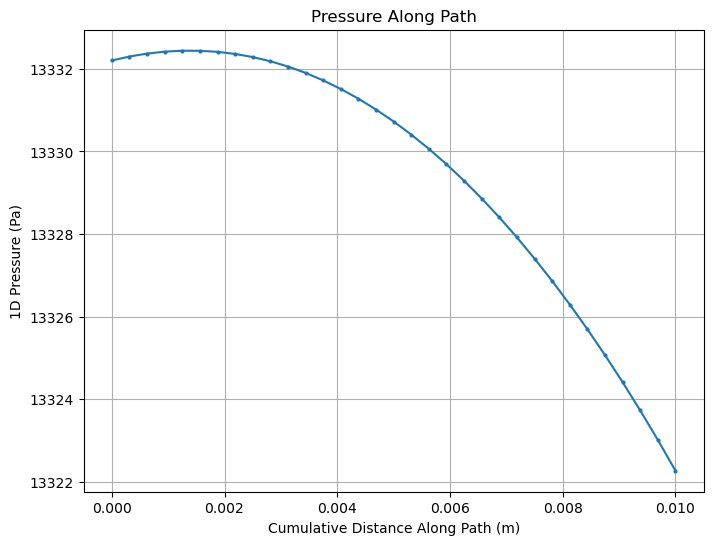

In [11]:
from graphnics import *
from xii import *
import matplotlib.pyplot as plt

def get_cells_along_path(G, path, tolerance = DOLFIN_EPS):
    if not G.mesh:
        raise ValueError("FenicsGraph object meshes not initialized. Call .make_mesh()")
    
    # List for global vertices
    global_vertices = []
    global_coords = G.mesh.coordinates()

    # For all node pairs in the path
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if G.has_edge(u, v):
            edge, forward = (u, v), True
        elif G.has_edge(v, u):
            edge, forward = (v, u), False
        else:
            raise ValueError(f"No edge between {u} and {v} in the graph.")
        if not "submesh" in G.edges[edge]:
            raise ValueError("FenicsGraph object submeshes not initialized. Call .make_submeshes()")
        submesh = G.edges[edge]["submesh"]
        coords = submesh.coordinates()

        # Map local submesh vertex indices to global mesh vertex indices
        if hasattr(submesh, 'entity_map'):
            local_to_global = submesh.entity_map(0)
        else:
            local_to_global = []
            for local_pt in coords:
                matches = np.where(np.all(np.isclose(global_coords, local_pt, atol = tolerance), axis=1))[0]
                if len(matches) == 0:
                    raise ValueError(f"No matching global vertex for local coordinate: {local_pt}")
                local_to_global.append(matches[0])
            local_to_global = np.array(local_to_global)

        # Get the tangent vector for the current edge, representing its direction
        tangent = G.edges[edge]["tangent"]
        if not forward:
            tangent = -tangent
        proj = np.dot(coords, tangent)
        sorted_local_indices = np.argsort(proj)

        # Convert the sorted local indices to their corresponding global vertex indices
        ordered_globals = [local_to_global[idx] for idx in sorted_local_indices]
        if i > 0 and ordered_globals[0] == global_vertices[-1]:
            ordered_globals = ordered_globals[1:]
        global_vertices.extend(ordered_globals)
    return global_vertices

def plot_path_pressure(G, uh1d, path):
    node_ids = get_cells_along_path(G, path)
    mesh = uh1d.function_space().mesh()
    coords = mesh.coordinates()
    pressure = uh1d.compute_vertex_values(mesh)
    path_coords, path_pressure = coords[node_ids], pressure[node_ids]
    
    print("Node Pressure Data:")
    for n, p in zip(node_ids, path_pressure):
        print(f"Node {n}: Pressure {p:.1f}")
        
    cum_dist = np.concatenate(([0], np.cumsum(np.linalg.norm(np.diff(path_coords, axis=0), axis=1))))
    fig = plt.figure(figsize=(8, 6))
    plt.plot(cum_dist, path_pressure, marker='o', markersize=2)
    plt.xlabel('Cumulative Distance Along Path (m)')
    plt.ylabel('1D Pressure (Pa)')
    plt.title('Pressure Along Path')
    plt.grid(True)
    return fig

plot_path_pressure(TEST_GRAPH, TEST_CUBES_SOLVER.uh1d, [0, 1])

In [ ]:
import scipy

def compute_flow(x, solver):
    solution = solver.solve(
        gamma = x[0],
        gamma_a = x[1],
        gamma_R = x[2],
        mu = 1.0e-3,
        k_t = 1.0e-10,
        P_in = 100.0 * 133.322,
        P_cvp = 1.0 * 133.322
    )
    return solver.compute_net_flow_all_dolfin()

def objective_log(y, solver, target):
    x = np.exp(y)
    val = compute_flow(x, solver) - target
    return val * val

def optimization_callback(xk):
    current_params = np.exp(xk)
    print(f"Optimization iteration:")
    print(f"  Current log_params: {xk}")
    print(f"  Current parameters (gamma, gamma_a, gamma_R): {current_params}")

x0 = [3.587472583336982e-05, 8.220701444028143e-08, 8.587334091365098e-08]
log_x0 = np.log(x0)

result = scipy.optimize.minimize(
    objective_log,
    log_x0,
    args=(TEST_CUBES_SOLVER, TARGET_FLOW),
    method='Nelder-Mead',
    options={'maxiter': 50},
    callback=optimization_callback
)

optimized_log_params = result.x
optimized_params = np.exp(optimized_log_params)

print("Optimized parameters:")
print("gamma =", optimized_params[0])
print("gamma_a =", optimized_params[1])
print("gamma_R =", optimized_params[2])
print("Achieved flow =", compute_flow(optimized_params, TEST_CUBES_SOLVER))

In [10]:
import numpy as np
import pandas as pd
import pytz
import datetime

x_default = [3.587472583336982e-05, 8.220701444028143e-08, 8.587334091365098e-08]

def compute_flow(x, solver):
    solver.solve(
        gamma = x[0],
        gamma_a = x[1],
        gamma_R = x[2],
        mu = 1.0e-3,
        k_t = 1.0e-10,
        P_in = 100.0 * 133.322,
        P_cvp = 1.0 * 133.322
    )
    data = [
        solver.compute_net_flow_all_dolfin(),
        solver.compute_lower_cube_flux_out(),
        solver.compute_upper_cube_flux_in(),
        solver.compute_upper_cube_flux_out(),
        solver.compute_upper_cube_flux()
    ]
    return data

def sweep_variable(variable_name, variable_values, default, solver, directory = None):
    variable_index = -1
    rows = []
    match variable_name:
        case "gamma": variable_index = 0
        case "gamma_a": variable_index = 1
        case "gamma_R": variable_index = 2
        case "k_v": variable_index = 3
        case _: raise ValueError("Invalid variable choice")
    for value in variable_values:
        x = default[:]
        x[variable_index] = value
        results = compute_flow(x, solver)
        rows.append({
            variable_name: value,
            "net_flow": results[0],
            "lower_cube_flux_out": results[1],
            "upper_cube_flux_in": results[2],
            "upper_cube_flux_out": results[3],
            "upper_cube_flux": results[4]
        })
    df = pd.DataFrame(rows).set_index(variable_name)
    if directory is not None:
        os.makedirs(directory, exist_ok=True)
        cst = pytz.timezone("America/Chicago")
        now = datetime.datetime.now(cst)
        timestamp = now.strftime("%Y%m%d_%H%M")
        filename = os.path.join(directory, f"{variable_name}_sweeps_{timestamp}.csv")
        df.to_csv(filename)
    return df

data = sweep_variable("gamma", np.logspace(-10, 2, 50), x_default, TEST_CUBES_SOLVER, directory = EXPORT_PATH)

In [ ]:
import pytz, datetime, scipy.optimize, pandas as pd

def compute_flow(x, solver):
    solver.solve(
        gamma = x[0],
        gamma_a = x[1],
        gamma_R = x[2],
        mu = 1.0e-3,
        k_t = 1.0e-10,
        P_in = 100.0 * 133.322,
        P_cvp = 1.0 * 133.322
    )
    return [
        solver.compute_net_flow_all_dolfin(),
        solver.compute_lower_cube_flux_out(),
        solver.compute_upper_cube_flux_in(),
        solver.compute_upper_cube_flux_out(),
        solver.compute_upper_cube_flux()
    ]

def objective_log_free(y_free, solver, target, fixed_index, fixed_value, free_indices):
    log_x = np.zeros(3)
    log_x[fixed_index] = np.log(fixed_value)
    for i, idx in enumerate(free_indices):
        log_x[idx] = y_free[i]
    x = np.exp(log_x)
    net_flow = compute_flow(x, solver)[0]
    return (net_flow - target)**2

def optimization_callback(yk, fixed_index, fixed_value, free_indices):
    log_x = np.zeros(3)
    log_x[fixed_index] = np.log(fixed_value)
    for i, idx in enumerate(free_indices):
        log_x[idx] = yk[i]
    current_params = np.exp(log_x)
    print("Optimization iteration:")
    print(f"  Fixed index {fixed_index} at value {fixed_value}")
    print(f"  Current log_params: {log_x}")
    print(f"  Current parameters (gamma, gamma_a, gamma_R): {current_params}")

def sweep_variable(variable_name, variable_values, default, solver, directory=None, target_flow=5.0e-6):
    match variable_name:
        case "gamma":
            variable_index = 0
        case "gamma_a":
            variable_index = 1
        case "gamma_R":
            variable_index = 2
        case _:
            raise ValueError("Invalid variable choice")

    free_indices = [i for i in range(3) if i != variable_index]

    rows = []
    for value in variable_values:
        fixed_value = value
        log_default = np.log(default)
        y0 = log_default[free_indices]
        result = scipy.optimize.minimize(
            objective_log_free,
            y0,
            args=(solver, target_flow, variable_index, fixed_value, free_indices),
            method='Nelder-Mead',
            options={'maxiter': 20},
            callback=lambda yk, fi=variable_index, fv=fixed_value, fi_list=free_indices: optimization_callback(yk, fi, fv, fi_list)
        )
        log_x_opt = np.zeros(3)
        log_x_opt[variable_index] = np.log(fixed_value)
        for i, idx in enumerate(free_indices):
            log_x_opt[idx] = result.x[i]
        x_opt = np.exp(log_x_opt)
        flows = compute_flow(x_opt, solver)
        rows.append({
            variable_name: value,
            "net_flow":          flows[0],
            "lower_cube_flux_out": flows[1],
            "upper_cube_flux_in":  flows[2],
            "upper_cube_flux_out": flows[3],
            "upper_cube_flux":     flows[4],
            "gamma_opt":  x_opt[0],
            "gamma_a_opt": x_opt[1],
            "gamma_R_opt": x_opt[2],
        })

    df = pd.DataFrame(rows).set_index(variable_name)
    
    if directory is not None:
        os.makedirs(directory, exist_ok=True)
        cst = pytz.timezone("America/Chicago")
        now = datetime.datetime.now(cst)
        timestamp = now.strftime("%Y%m%d_%H%M")
        filename = os.path.join(directory, f"{variable_name}_sweeps_{timestamp}.csv")
        df.to_csv(filename)
    return df

x_default = [3.587472583336982e-05, 8.220701444028143e-08, 8.587334091365098e-08]

data = sweep_variable(
    "gamma",
    np.logspace(-10, 2, 20),
    x_default,
    TEST_CUBES_SOLVER,
    directory = EXPORT_PATH,
    target_flow = 5.0e-6
)

data.head()

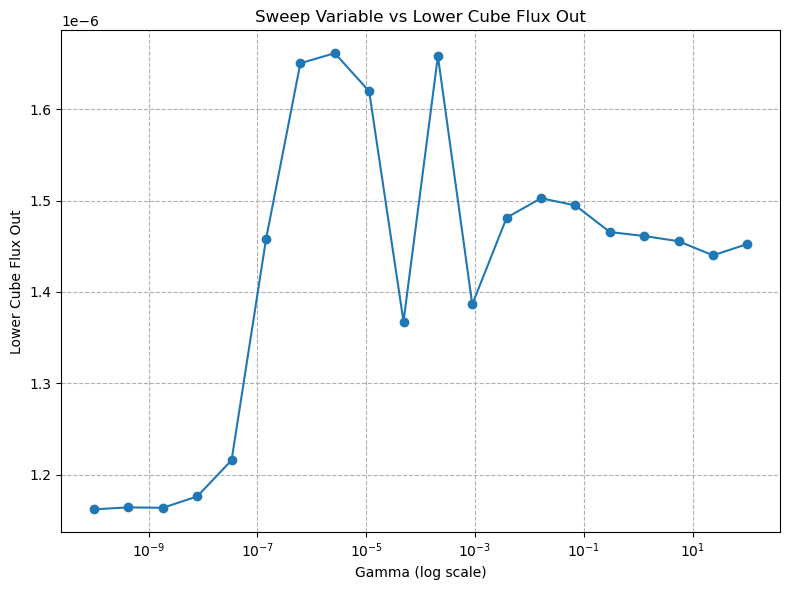

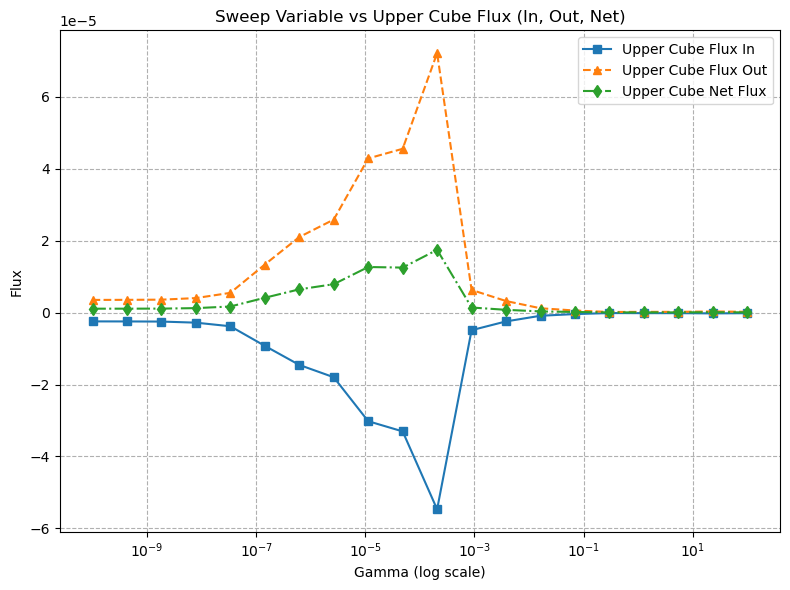

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("export/gamma_sweeps_20250428_1423.csv")

data = data.set_index('gamma')

def plot_flow_data_semilog(df):
    x = df.index.values

    plt.figure(figsize=(8,6))
    plt.semilogx(x, df['lower_cube_flux_out'], marker='o', linestyle='-')
    plt.xlabel('Gamma (log scale)')
    plt.ylabel('Lower Cube Flux Out')
    plt.title('Sweep Variable vs Lower Cube Flux Out')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,6))
    plt.semilogx(x, df['upper_cube_flux_in'],  marker='s', linestyle='-',  label='Upper Cube Flux In')
    plt.semilogx(x, df['upper_cube_flux_out'], marker='^', linestyle='--', label='Upper Cube Flux Out')
    plt.semilogx(x, df['upper_cube_flux'],     marker='d', linestyle='-.', label='Upper Cube Net Flux')
    plt.xlabel('Gamma (log scale)')
    plt.ylabel('Flux')
    plt.title('Sweep Variable vs Upper Cube Flux (In, Out, Net)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

plot_flow_data_semilog(data)

In [ ]:
cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
output_dir = os.path.join(EXPORT_PATH, f"output_sweeps_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

df_results = sweep_for_param('gamma', TEST_SWEEP_CONFIG, TEST_SWEEP_DEFAULT, output_dir)
plot_results(df_results, TEST_SWEEP_CONFIG, output_dir)
save_data_to_csv(df_results, output_dir)

In [ ]:
df_results, sweep_configs = perform_all_sweeps(num_points=50)
plot_results(df_results, sweep_configs, output_dir)
save_data_to_csv(df_results, output_dir)